# Stacked carton dataset for detection and segmentation  

In this Nodebook we download and explore Stacked Carton Dataset  
[Link to paper](https://arxiv.org/pdf/2102.12808)
[SCD: A Stacked Carton Dataset for Detection and Segmentation](https://arxiv.org/abs/2102.12808)

https://github.com/yancie-yjr/scd.github.io

# Setup

In [ ]:
!pip install boto3 opencv-python

from IPython.display import clear_output
clear_output()

In [ ]:
import os
import pandas as pd
import boto3
import cv2
import numpy as np
import zipfile
import json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

In [ ]:
from google.colab import userdata

OPENAI_KEY = userdata.get('OPENAI_KEY')

AWS_BRG_ACCESS_KEY = userdata.get('AWS_BRG_ACCESS_KEY')
AWS_BRG_SECRET_ACCESS_KEY = userdata.get('AWS_BRG_SECRET_ACCESS_KEY')

s3_client_BRG = s3_client = boto3.client('s3',
            aws_access_key_id = AWS_BRG_ACCESS_KEY,
            aws_secret_access_key = AWS_BRG_SECRET_ACCESS_KEY)



rekognition_client = boto3.client('rekognition',
                               region_name = 'us-east-1',
                               aws_access_key_id = AWS_BRG_ACCESS_KEY,
                               aws_secret_access_key = AWS_BRG_SECRET_ACCESS_KEY)


ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')

# Download Stacked Carton Dataset

https://github.com/yancie-yjr/scd.github.io
* total images: 16,136
* total instance masks: 250,000  

the ds is divided into 2 parts:
* Live Stacked Carton Dataset (collected from warehouse): 7735 images
* Online Staked Carbon Dataset (collected from internet): 8401 images

Labels:
* Carton (LSCD, OSCD)
* Carton-inner-all (LSCD)
* Carton-inner-occlusion (LSCD)
* Carton-outer-all (LSCD)
* Carton-outer-occlusion (LSCD)

In [ ]:
import gdown

Since we are going to download the dataset to our Gdrive, let's attach the Gdrive to the Notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

let's change our current directory to the one we will use as our project folder:

In [ ]:
path = '/content/drive/MyDrive/0_Projects/drone-warehouse/'
os.chdir(path)

this is url of the Gdrive where SCD is stored

In [ ]:
url='https://drive.google.com/file/d/1nJKS5YwsfxciRXg9ZooGcgdoXuKESMaj/view?usp=sharing'

we are going to use the url above to download 2 zip files:
* OSCD.zip
* LSCD.zip  

which correspond to the 2 sub-datasets as described above:
* Online Staked Carbon Dataset
* Live Staked Carbon Dataset

## download zip archives
there are 3 zip archives to download:
* OSCD.zip
* LSCD.zip
* LSCD_occlusions.zip

In [ ]:
url='https://drive.google.com/file/d/1YeZ4mg_qZ4dBvKKfgGF8RQcyOMNoMp37/view?usp=sharing'
file_id = url.split('/d/')[1].split('/')[0]
print(file_id)
download_url = f'https://drive.google.com/uc?id={file_id}'
output = './images/OSCD.zip'

# Download the file
gdown.download(download_url, output, quiet=False)

In [ ]:
url='https://drive.google.com/file/d/1JRk_YjPpGcTCB-bvlJ37KsI5Sx1tfbUc/view?usp=sharing'
file_id = url.split('/d/')[1].split('/')[0]
print(file_id)
download_url = f'https://drive.google.com/uc?id={file_id}'
output = './images/LSCD.zip'

# Download the file
gdown.download(download_url, output, quiet=False)

In [ ]:
url='https://drive.google.com/file/d/1nJKS5YwsfxciRXg9ZooGcgdoXuKESMaj/view?usp=sharing'
file_id = url.split('/d/')[1].split('/')[0]
print(file_id)
download_url = f'https://drive.google.com/uc?id={file_id}'
output = './images/LSCD_occlusions.zip'

# Download the file
gdown.download(download_url, output, quiet=False)

## what's inside the zip archives ?

### OSCD.zip

In [ ]:
zip_file_path = './images/OSCD.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the list of filenames
    oscd_filenames = zip_ref.namelist()
oscd_fn_df = pd.DataFrame(oscd_filenames,
                          columns = ['file_name'])
oscd_fn_df.shape

(25212, 1)

In [ ]:
oscd_fn_df.query("file_name.str.contains('json')")['file_name'].str.split('/').str[0].value_counts()

file_name
labelme        8401
coco_carton       2
Name: count, dtype: int64

there are 2 types of json files:
* dataset annotations
* individual image - related

In [ ]:
oscd_fn_df.query("file_name.str.contains('coco_carton.*json')").file_name.tolist()

['coco_carton/oneclass_carton/annotations/instances_train2017.json',
 'coco_carton/oneclass_carton/annotations/instances_val2017.json']

In [ ]:
labelme_df = oscd_fn_df.query("file_name.str.contains('labelme.*.jpg')")
print(labelme_df.shape)
labelme_df.head()

(8401, 1)


,file_name
8410,labelme/net (10).jpg
8412,labelme/net (100).jpg
8414,labelme/net (1000).jpg
8416,labelme/net (1001).jpg
8418,labelme/net (1002).jpg


### individual image-related files

labelme/net (14217).jpg


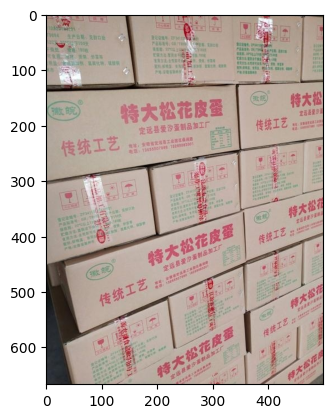

In [ ]:
file_name = labelme_df.sample(1)['file_name'].values[0]
print(file_name)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(file_name) as file:
        file_content = file.read()
        image = Image.open(BytesIO(file_content))
plt.imshow(image)

In [ ]:
suffix = file_name.split('/')[-1].split('.')[0]
print(suffix)
df = oscd_fn_df.query("file_name.str.contains(@suffix, regex=False)")
df

net (14217)


,file_name
1451,coco_carton/oneclass_carton/images/train2017/n...
11684,labelme/net (14217).jpg
11685,labelme/net (14217).json


In [ ]:

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  with zip_ref.open(file_name.replace('.jpg','.json')) as file:
    file_content = file.read()
    file_text = file_content.decode('utf-8')

json_data = json.loads(file_text)
list(json_data)

['version',
 'flags',
 'shapes',
 'imagePath',
 'imageData',
 'imageHeight',
 'imageWidth']

In [ ]:
json_data['imagePath'], json_data['imageData']

In [ ]:
json_data['shapes']

coco_carton/oneclass_carton/images/train2017/net (14217).jpg


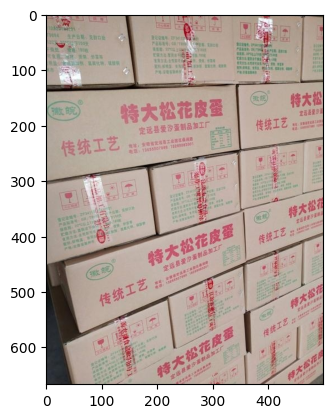

In [ ]:
file_name = df.iloc[0,0]
print(file_name)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(file_name) as file:
        file_content = file.read()
        image = Image.open(BytesIO(file_content))
plt.imshow(image)

In [ ]:
oscd_fn_df.query("file_name.str.contains('5693')")

,file_name
4889,coco_carton/oneclass_carton/images/train2017/n...
19432,labelme/net (5693).jpg
19433,labelme/net (5693).json


In [ ]:
file_name = 'coco_carton/oneclass_carton/annotations/instances_train2017.json'
zip_file_path = './images/OSCD.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(file_name) as file:
        file_content = file.read()
        image = Image.open(BytesIO(file_content))

image

['info', 'license', 'images', 'annotations', 'categories']


(7401, 148568)

In [ ]:
oscd_images_df = pd.DataFrame(json_data['images'])
oscd_annot_df = pd.DataFrame(json_data['annotations'])
oscd_images_df.shape, oscd_annot_df.shape

((7401, 4), (148568, 7))

In [ ]:
oscd_annot_df

,id,image_id,category_id,segmentation,bbox,iscrowd,area
0,0,0,1,"[[0, 194, 48, 197, 48, 76, 36, 73, 0, 76]]","[0, 73, 48, 124]",0,5952.0
1,1,0,1,"[[49, 198, 136, 203, 139, 172, 137, 70, 47, 76]]","[47, 70, 92, 133]",0,12236.0
2,2,0,1,"[[139, 201, 247, 212, 256, 59, 138, 66]]","[138, 59, 118, 153]",0,18054.0
3,3,0,1,"[[248, 212, 378, 221, 410, 218, 433, 85, 403, ...","[248, 50, 185, 171]",0,31635.0
4,4,0,1,"[[413, 220, 432, 217, 452, 108, 435, 88]]","[413, 88, 39, 132]",0,5148.0
...,...,...,...,...,...,...,...
148563,148563,7400,1,"[[309, 32, 308, 47, 323, 46, 323, 32]]","[308, 32, 15, 15]",0,225.0
148564,148564,7400,1,"[[331, 113, 313, 114, 312, 117, 308, 117, 309,...","[308, 113, 23, 29]",0,667.0
148565,148565,7400,1,"[[331, 142, 331, 169, 309, 169, 309, 142]]","[309, 142, 22, 27]",0,594.0
148566,148566,7400,1,"[[331, 198, 307, 199, 307, 175, 309, 169, 331,...","[307, 169, 24, 30]",0,720.0


### image_annotations

In [ ]:
oscd_fn_df.query("file_name.str.contains('coco_carton.*json')").file_name.tolist()

['coco_carton/oneclass_carton/annotations/instances_train2017.json',
 'coco_carton/oneclass_carton/annotations/instances_val2017.json']

In [ ]:
fn = 'coco_carton/oneclass_carton/annotations/instances_train2017.json'
print(fn)
zip_file_path = './images/OSCD.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  with zip_ref.open(fn) as file:
    file_content = file.read()
    file_text = file_content.decode('utf-8')

json_data = json.loads(file_text)
print(list(json_data))
train_images = json_data['images']
train_annotations = json_data['annotations']
len(train_images), len(train_annotations)

coco_carton/oneclass_carton/annotations/instances_train2017.json
['info', 'license', 'images', 'annotations', 'categories']


(7401, 148568)

In [ ]:
oscd_image_train_df = pd.DataFrame(train_images)
oscd_image_train_df.shape

(7401, 4)

In [ ]:
oscd_image_train_df

,height,width,id,file_name
0,667,500,0,net (6785).jpg
1,500,500,1,net (358).jpg
2,667,500,2,net (7985).jpg
3,667,500,3,net (7083).jpg
4,562,371,4,net (13657).jpg
...,...,...,...,...
7396,113,150,7396,net (3798).jpg
7397,225,300,7397,net (5314).jpg
7398,333,500,7398,net (341).jpg
7399,500,500,7399,net (12495).jpg


In [ ]:
oscd_annot_train_df = pd.DataFrame(train_annotations)
oscd_annot_train_df.shape

(148568, 7)

In [ ]:
oscd_annot_train_df

,id,image_id,category_id,segmentation,bbox,iscrowd,area
0,0,0,1,"[[0, 194, 48, 197, 48, 76, 36, 73, 0, 76]]","[0, 73, 48, 124]",0,5952.0
1,1,0,1,"[[49, 198, 136, 203, 139, 172, 137, 70, 47, 76]]","[47, 70, 92, 133]",0,12236.0
2,2,0,1,"[[139, 201, 247, 212, 256, 59, 138, 66]]","[138, 59, 118, 153]",0,18054.0
3,3,0,1,"[[248, 212, 378, 221, 410, 218, 433, 85, 403, ...","[248, 50, 185, 171]",0,31635.0
4,4,0,1,"[[413, 220, 432, 217, 452, 108, 435, 88]]","[413, 88, 39, 132]",0,5148.0
...,...,...,...,...,...,...,...
148563,148563,7400,1,"[[309, 32, 308, 47, 323, 46, 323, 32]]","[308, 32, 15, 15]",0,225.0
148564,148564,7400,1,"[[331, 113, 313, 114, 312, 117, 308, 117, 309,...","[308, 113, 23, 29]",0,667.0
148565,148565,7400,1,"[[331, 142, 331, 169, 309, 169, 309, 142]]","[309, 142, 22, 27]",0,594.0
148566,148566,7400,1,"[[331, 198, 307, 199, 307, 175, 309, 169, 331,...","[307, 169, 24, 30]",0,720.0


### view images and visualize carton annotations

net (6853).jpg
coco_carton/oneclass_carton/images/train2017/net (6853).jpg


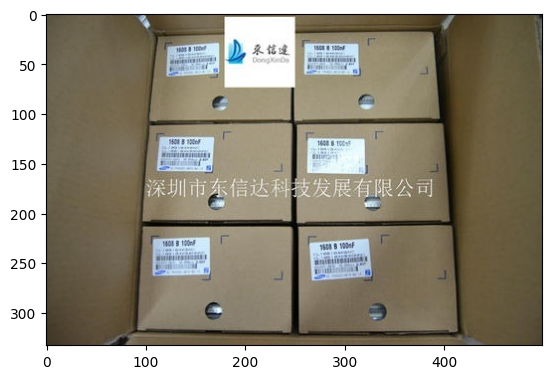

In [165]:
idx = 189
zip_file_path = './images/OSCD.zip'
image_suffix = oscd_image_train_df.loc[idx,'file_name']
print(image_suffix)
img_fn = f"coco_carton/oneclass_carton/images/train2017/{image_suffix}"
print(img_fn)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  with zip_ref.open(img_fn) as file:
    file_content = file.read()
    image = Image.open(BytesIO(file_content))
plt.imshow(image);
numpy_image = np.array(image)
image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)

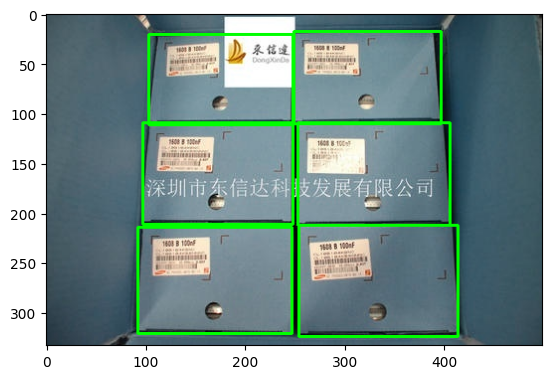

In [166]:
annot_image_df = annot_train_df.query("image_id == @idx")
for row in annot_image_df.itertuples():
  x, y, w, h = row.bbox
  cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(image);

## LSCD.zip

In [ ]:
zip_file_path = './images/LSCD.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the list of filenames
    lscd_filenames = zip_ref.namelist()

lscd_fn_df = pd.DataFrame(lscd_filenames,
                          columns = ['file_name'])
lscd_fn_df.shape

(7741, 1)

In [ ]:
lscd_fn_df

,file_name
0,annotations/
1,annotations/instances_train2017.json
2,annotations/instances_val2017.json
3,images/
4,images/train2017/
...,...
7736,images/val2017/y (76).jpg
7737,images/val2017/y (80).jpg
7738,images/val2017/y (91).jpg
7739,images/val2017/y (93).jpg


In [ ]:
lscd_fn_df.query("file_name.str.contains('json')").file_name.tolist()

['annotations/instances_train2017.json', 'annotations/instances_val2017.json']

In [ ]:
file_name = 'annotations/instances_train2017.json'
zip_file_path = './images/LSCD.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(file_name) as file:
        file_content = file.read()
        file_text = file_content.decode('utf-8')

json_data = json.loads(file_text)
print(list(json_data))
len(json_data['images']), len(json_data['annotations'])

['info', 'license', 'images', 'annotations', 'categories']


(6735, 70838)

### image_annotations

In [ ]:
lscd_image_train_df = pd.DataFrame(json_data['images'])
lscd_image_train_df.shape

(6735, 4)

In [ ]:
lscd_image_train_df

,height,width,id,file_name
0,3680,2728,0,2850.jpg
1,2976,3968,1,6 (144).jpg
2,3809,2736,2,IMG_20191125_145411.jpg
3,5792,4344,3,y (18).jpg
4,3264,2001,4,2021.jpg
...,...,...,...,...
6730,3314,2131,6730,2948.jpg
6731,385,319,6731,1771.jpg
6732,531,263,6732,1675.jpg
6733,3999,2741,6733,2 (38).jpg


In [ ]:
lscd_annot_train_df = pd.DataFrame(json_data['annotations'])
lscd_annot_train_df.shape

(70838, 7)

In [ ]:
lscd_annot_train_df

,id,image_id,category_id,segmentation,bbox,iscrowd,area
0,0,0,1,"[[90.82352941176464, 3184.3529411764703, 1467....","[90.82352941176464, 3125.529411764706, 1376.47...",0,663944.636678
1,1,0,1,"[[1467.2941176470586, 3125.529411764706, 2331....","[1467.2941176470586, 3096.1176470588234, 864.7...",0,391660.899654
2,2,0,1,"[[2331.9999999999995, 3096.1176470588234, 2727...","[2302.5882352941176, 3070.0, 424.4117647058824...",0,190835.501730
3,3,0,1,"[[967.2941176470586, 2684.3529411764703, 2320....","[961.411764705882, 2654.941176470588, 1370.588...",0,661107.266436
4,4,0,1,"[[20.235294117646845, 2696.1176470588234, 967....","[20.235294117646845, 2678.470588235294, 947.05...",0,467958.477509
...,...,...,...,...,...,...,...
70833,70833,6734,1,"[[1846.9655172413795, 1842.7586206896553, 2447...","[1805.586206896552, 1842.0, 641.4137931034479,...",0,453899.788347
70834,70834,6734,1,"[[1891.7931034482763, 935.8620689655173, 2447....","[1891.7931034482763, 1.0, 555.2068965517237, 9...",0,519041.868014
70835,70835,6734,1,"[[1871.1034482758623, 939.3103448275863, 1933....","[1129.7241379310349, 0.0, 803.2758620689651, 9...",0,771144.827586
70836,70836,6734,1,"[[1174.5517241379312, 963.4482758620691, 474.5...","[313.0, 0.0, 861.5517241379312, 980.6896551724...",0,844914.863258


### view LSCD images and visualize carton annotations

In [155]:
lscd_fn_df.query("file_name.str.contains(@image_suffix)")

,file_name
2420,images/train2017/2850.jpg


6 (144).jpg
images/train2017/6 (144).jpg


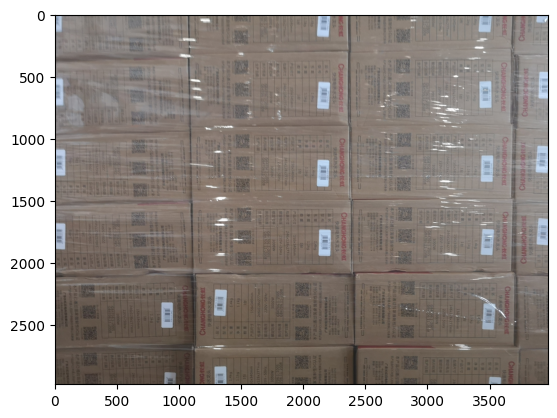

In [157]:
idx = 1
image_suffix = lscd_image_train_df.loc[idx,'file_name']
print(image_suffix)

img_fn = f"images/train2017/{image_suffix}"
print(img_fn)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  with zip_ref.open(img_fn) as file:
    file_content = file.read()
    image = Image.open(BytesIO(file_content))
plt.imshow(image);
numpy_image = np.array(image)
image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)

In [159]:
annot_image_df

,id,image_id,category_id,segmentation,bbox,iscrowd,area
21,21,1,1,"[[1075.0, 325.0, 1096.1538461538462, 915.38461...","[1075.0, 298.0769230769231, 1307.6923076923076...",0,807248.520710
22,22,1,1,"[[1088.4615384615383, 917.3076923076923, 1101....","[1088.4615384615383, 896.1538461538461, 1298.0...",0,786335.059172
23,23,1,1,"[[1100.0, 1500.0, 1113.4615384615383, 2090.384...","[1100.0, 1498.076923076923, 1298.0769230769229...",0,776349.852071
24,24,1,1,"[[1115.3846153846152, 2090.3846153846152, 1115...","[1115.3846153846152, 2090.3846153846152, 1292....",0,767928.994083
25,25,1,1,"[[2377.1929824561403, 312.2807017543859, 2380....","[2377.1929824561403, 275.43859649122805, 1333....",0,835087.719298
26,26,1,1,"[[2385.9649122807014, 899.9999999999999, 2391....","[2385.9649122807014, 889.4736842105262, 1321.0...",0,794949.215143
27,27,1,1,"[[2399.9999999999995, 1498.2456140350876, 2399...","[2399.9999999999995, 1485.9649122807016, 1300....",0,764035.087719
28,28,1,1,"[[2415.7894736842104, 2082.456140350877, 2410....","[2410.5263157894733, 2073.6842105263154, 1307....",0,779624.499846
29,29,1,1,"[[1077.9032258064517, 317.06451612903226, 2368...","[1077, 0, 1291.2258064516127, 317.06451612903226]",0,409401.885536
30,30,1,1,"[[1065.0, 355.7741935483871, 10.16129032258061...","[1, 0, 1076, 371.90322580645164]",0,400167.870968


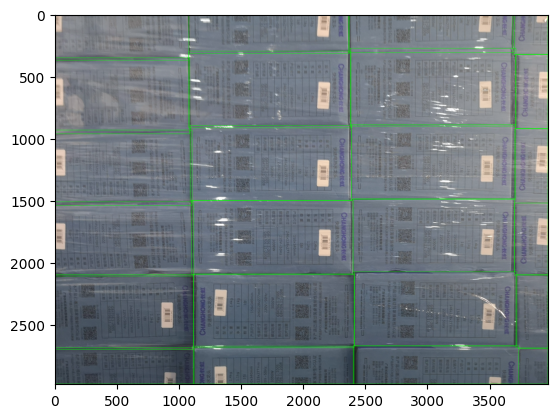

In [164]:
annot_image_df = lscd_annot_train_df.query("image_id == @idx")
for row in annot_image_df.itertuples():
    x, y, w, h = row.bbox
    cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
plt.imshow(image)


## LSCD_occlusions.zip

In [ ]:
zip_file_path = './images/LSCD_occlusions.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the list of filenames
    lscd_occlusions_filenames = zip_ref.namelist()
len(lscd_occlusions_filenames)

7742

In [ ]:
lscd_occlusions_filenames[:10]

['annotations/',
 'annotations/instances_train2017.json',
 'annotations/instances_val2017.json',
 'images/',
 'images/train2017/',
 'images/train2017/00.jpg',
 'images/train2017/00c1.jpg',
 'images/train2017/00c11.jpg',
 'images/train2017/00c12.jpg',
 'images/train2017/1 (1).jpg']

In [ ]:
file_name = 'annotations/instances_train2017.json'
zip_file_path = './images/LSCD_occlusions.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(file_name) as file:
        file_content = file.read()
        file_text = file_content.decode('utf-8')

json_data = json.loads(file_text)
print(list(json_data))
len(json_data['images']), len(json_data['annotations'])

['info', 'license', 'images', 'annotations', 'categories']


(6735, 71480)

In [ ]:
oscd_filenames_df = pd.DataFrame(oscd_filenames,
                                 columns = ['file_name'])
oscd_filenames_df['ds'] = 'oscd'
lscd_filenames_df = pd.DataFrame(lscd_filenames,
                                 columns = ['file_name'])
lscd_filenames_df['ds'] = 'lscd'

fin_df = pd.concat([oscd_filenames_df,lscd_filenames_df])
fin_df.shape, fin_df['ds'].value_counts()

((15483, 2),
 ds
 oscd    7742
 lscd    7741
 Name: count, dtype: int64)

# SCD dataset

In [ ]:
path = '/content/drive/MyDrive/0_Projects/drone-warehouse/'
os.chdir(path)

In [ ]:
scd_df = pd.read_parquet('./images/scd_df.parquet').reset_index()
scd_df.shape

(32954, 3)

In [ ]:
fn='coco_carton/oneclass_carton/annotations/instances_train2017.json'
zip_file_path = './images/OSCD.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  with zip_ref.open(fn) as file:
    file_content = file.read()
    file_text = file_content.decode('utf-8')

json_data = json.loads(file_text)
print(list(json_data))
train_images = json_data['images']
train_annotations = json_data['annotations']
len(train_images), len(train_annotations)

['info', 'license', 'images', 'annotations', 'categories']


(7401, 148568)